In [5]:
import sys
sys.path.append("/data1/andrew/meng/mixehr/meng/VAE-EHR/src")
import os

print(sys.version)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [6]:
from typing import List, Tuple
import numpy as np 
import pandas as pd

import torch
from torch import nn, optim

In [7]:
from vae import VAE
from vae import VAETrainer
from config_reader import Config
from icd_analysis_helper import ICDAnalysisHelper
from visualizer_helper import Visualizer

In [10]:
config = Config('./config.ini')
config.__dict__

{'patient_icd_path': '/data1/andrew/meng/mixehr/data/Mimic/andrew_outputs/PATIENT_ICD_BINARY.csv',
 'icd9codes_path': '/data1/andrew/meng/mixehr/data/Mimic/mimic-iii-clinical-database-1.4/D_ICD_DIAGNOSES.csv.gz',
 'experiment_name': '200113_patient_clusters_25_latent_dim',
 'encoder_dim': [(250, 500), (500, 250), (250, 100)],
 'latent_dim': 25,
 'decoder_dim': [],
 'use_relu': True}

In [9]:
patient_icd_df=pd.read_csv(config.patient_icd_path, sep=' ')
patient_icd_data = patient_icd_df.drop('SUBJECT_ID', axis=1)
data = torch.tensor(patient_icd_data.values).float()
print(data.shape)

icd9codes = pd.read_csv(config.icd9codes_path)
icd_analyzer = ICDAnalysisHelper(icd9codes_df = icd9codes, patient_icd_df = patient_icd_df)

visualizer = Visualizer()

torch.Size([46520, 6984])


In [15]:
print("Feature_dim: {}".format(data.shape[1]))
model = VAE(
    feature_dim = data.shape[1], 
    encoder_dim = config.encoder_dim,
    latent_dim = config.latent_dim,
    decoder_dim = config.decoder_dim,
    use_relu= config.use_relu
)

optimizer = optim.Adam(model.parameters(), lr=0.001)
print(type(optimizer))

Feature_dim: 6984
<class 'torch.optim.adam.Adam'>


In [16]:
experiment_name=config.experiment_name
epoch = 40
model.load_state_dict(torch.load("./VAE_exp_{}_epoch_{}.pkl".format(experiment_name, epoch)))

<All keys matched successfully>

In [17]:
trainer = VAETrainer(
    model=model, 
    optimizer=optimizer,
    experiment_name=experiment_name
)

In [18]:
latent, means, var = trainer.encode_data(data)

In [19]:
X_umap = visualizer.umap_embedding(latent.cpu().detach().numpy())
X_umap_means = visualizer.umap_embedding(means.cpu().detach().numpy())

Obtained TSNE


/data1/andrew/meng/mixehr/meng/VAE-EHR/src/visualizer_helper.py:18: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  return UMAP(n_components=n_components).fit_transform(X)


In [21]:
heart_keywords = ['heart', 'atrial', 'coronary', 'hypertension', 'vascular']
heart_patient_idxs = icd_analyzer.get_patients_idxs_with_disease_keywords(substrings=heart_keywords, case_sensitive=False)

#icd_analyzer.lookup_icds(icd9codes, ["4019", "41401"])

heart_colors = np.array([0 for i in range(X_umap.shape[0])])
heart_colors[heart_patient_idxs] = 100

Occurences of heart before filter: 97
After: 77
Occurences of atrial before filter: 4
After: 4
Occurences of coronary before filter: 21
After: 18
Occurences of hypertension before filter: 61
After: 27
Occurences of vascular before filter: 116
After: 85
Total Relevant ICDs: 211
Patients with disease(s): 29510


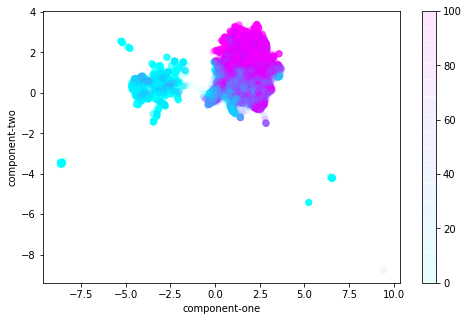

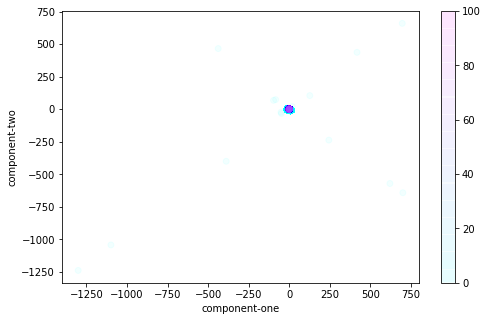

In [24]:
visualizer.plot2d(
    X=X_umap, 
    filename="Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_heart_umap"), 
    colors=heart_colors,
)
visualizer.plot2d(
    X=X_umap_means, 
    filename="Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_heart_umap_means"), 
    colors=heart_colors,
)

Occurences of congenital before filter: 167
After: 86
Occurences of infant before filter: 38
After: 21
Occurences of newborn before filter: 117
After: 77
Occurences of neonatal before filter: 21
After: 18
Occurences of born before filter: 195
After: 94
Occurences of birth before filter: 173
After: 39
Total Relevant ICDs: 335
Patients with disease(s): 8665


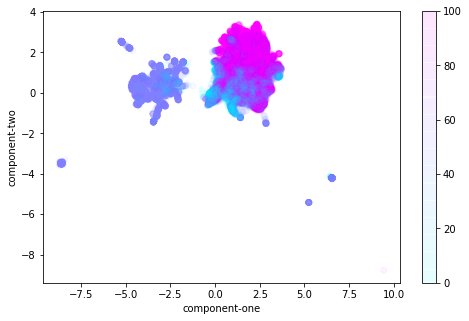

In [25]:
baby_keywords = ['congenital', 'infant', 'newborn', 'neonatal', 'born', 'birth']
baby_patient_idxs = icd_analyzer.get_patients_idxs_with_disease_keywords(substrings=baby_keywords, case_sensitive=False)

baby_heart_colors = np.array([0 for i in range(X_umap.shape[0])])
baby_heart_colors[heart_patient_idxs] = 100
baby_heart_colors[baby_patient_idxs] = 50

visualizer.plot2d(X_umap, "Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_baby_heart_umap"), colors=baby_heart_colors)

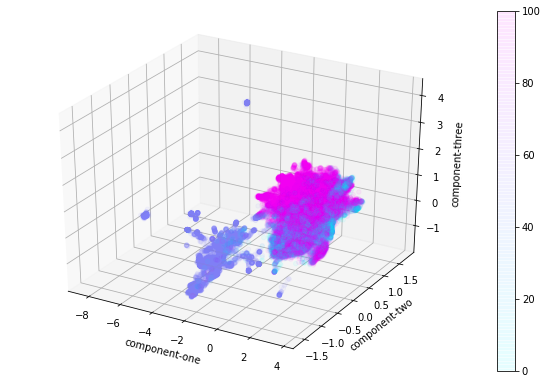

In [26]:
X_umap_3d = visualizer.umap_embedding(latent.cpu().detach().numpy(), n_components=3)

visualizer.plot3d(
    X=X_umap_3d, 
    filename="Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_heart_umap_3D"), 
    colors=baby_heart_colors,
)